# Burst Reverberation Toolbox (BRT) Example
Created by: Kartik Pradeepan

BRT will generate raster, spike density function, detect burst, identify if network is reverberating, and calculate basic features.

## Load modules

In [1]:
import pandas as pd
from functions.organize_spikelist import organize_spikelist
import functions.burst_reverberation_toolbox_v2 as brt
import numpy as np
import functions.detect_reverb_clusters as drc
import matplotlib.pyplot as plt
import seaborn as sns

## Important constants, storage variables

In [2]:
fs = 12500  # hertz
duration = 300  # seconds
start_time = 0  # seconds
burst_prom = 0.75  # hertz
noise_threshold = 1.05  # hertz

WELL_TO_ANALYZE = "C3"

raster = []
sdf = []
numSpikes = []

filename = "data/sample_data.csv"

## Load and pre-process the data

In [3]:
spikelist = pd.read_csv(filename, on_bad_lines="skip", low_memory=False)
spikelist

,Investigator,Unnamed: 1,Time (s),Electrode,Amplitude(mV)
0,Experiment ID,NaN,0.00184,A1_76,0.063715
1,Description,NaN,0.00824,C1_51,0.022425
2,NaN,NaN,0.01160,B1_47,0.054846
3,Maestro Settings,NaN,0.01984,A1_42,0.061184
4,Original File Time,07/17/2018 12:44:33,0.02224,C1_41,0.037415
...,...,...,...,...,...
2135157,NaN,NaN,299.74960,C3_12,0.034827
2135158,NaN,NaN,299.74968,A4_61,0.027035
2135159,NaN,NaN,299.74984,C3_73,0.018946
2135160,NaN,NaN,299.75000,C3_11,0.024182


As we can see, the spikelist csv file (from Axion Biosystems) contains 5 columns. We only need columns "Time (s)", and "Electrode". Additionally, at the end of the file, there is some metadata that we need to remove.

In [4]:
spikelist = organize_spikelist(spikelist)

Now that we've cleaned up the spikelist csv file, we want to find only the data that relates to the well we want to analyze (WELL_TO_ANALYZE).

In [5]:
well_spiketimes = spikelist[spikelist['Electrode'].str.contains(WELL_TO_ANALYZE)]

## Generate the Raster Plot and Spike Density Function (SDF)

In [6]:
gaussian_kernel = brt.generate_gaussian_kernel(sigma=0.055)
channels_in_well = sorted(pd.unique(well_spiketimes['Electrode']))

for channel in channels_in_well:
        spiketrain = well_spiketimes[well_spiketimes['Electrode'] == channel].filter(regex="Time").values
        spiketrain = spiketrain[(spiketrain >= start_time) & (spiketrain < (start_time + duration))] - start_time
        raster.append(spiketrain)
        spikematrix = brt.generate_spikematrix(spiketrain, fs=12500, duration=duration)
        sdf.append(brt.generate_sdf(spikematrix, gaussian_kernel))
        numSpikes.append(len(spiketrain))
weighted_network_sdf = np.average(sdf, axis=0, weights=numSpikes)

## Plot Raster Plot and Spike Density Function

Text(0.5, 0, 'Active channels')

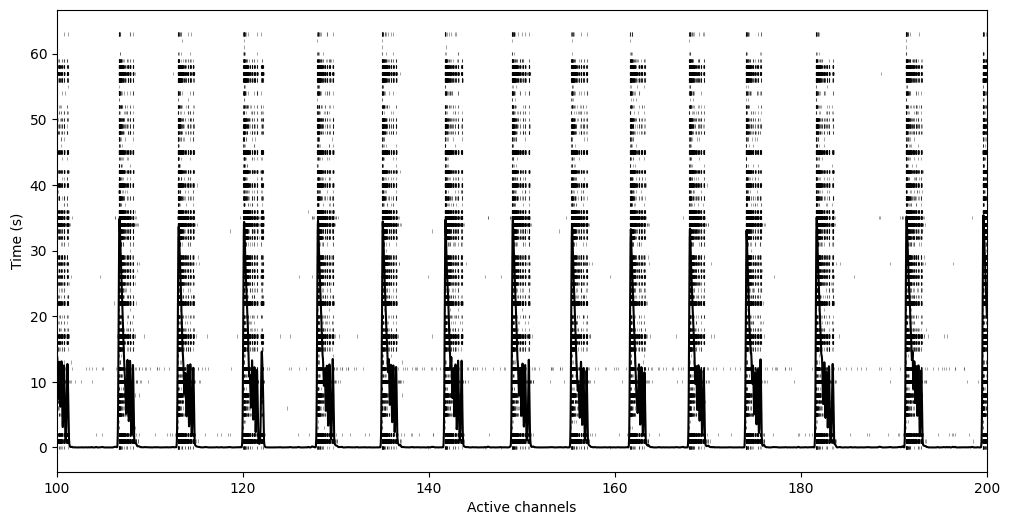

In [7]:
fig = plt.figure(figsize=(12, 6))

plt.eventplot(raster, color='black', linelengths=0.5, linewidths=0.75, alpha=0.35)
t = np.arange(0, len(weighted_network_sdf) / fs, 1 / fs)
plt.plot(t, weighted_network_sdf, 'black', 3)
plt.xlim([100,200])
plt.ylabel("Time (s)")
plt.xlabel("Active channels")

## Burst Detection
Detects network bursts by finding peaks in the Spike Density Function that is above the noise threshold with a sufficient prominence.

In [8]:
burst_peaks = brt.detect_burst_peaks(weighted_network_sdf, height=noise_threshold, prom=burst_prom)
burst_borders = brt.detect_burst_borders(burst_peaks, weighted_network_sdf, threshold=noise_threshold * 0.8)

## Plot Burst Peaks on Raster-SDF

Text(0, 0.5, 'Active channels')

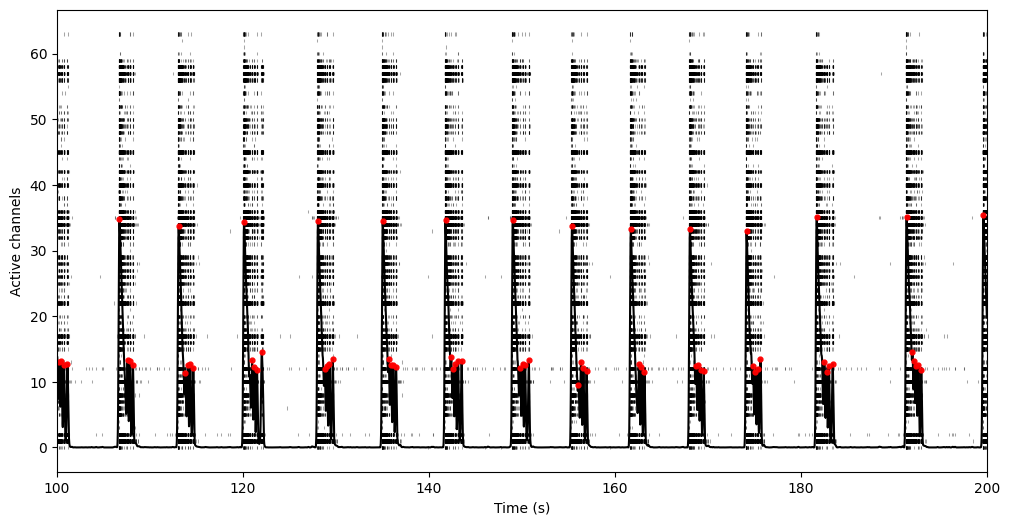

In [9]:
fig = plt.figure(figsize=(12, 6))

plt.eventplot(raster, color='black', linelengths=0.5, linewidths=0.75, alpha=0.35)
t = np.arange(0, len(weighted_network_sdf) / fs, 1 / fs)
plt.plot(t, weighted_network_sdf, 'black', 3)
plt.plot(burst_peaks, weighted_network_sdf[(burst_peaks*fs).astype(int)],'.', color='red', alpha=0.95, markersize=7)
plt.xlim([100,200])
plt.xlabel("Time (s)")
plt.ylabel("Active channels")


## Perform KMeans Clustering to determine if network is reverberating
Perform KMeans only if there are more than 2 bursts and attempt to cluster, and then plot the clusters.

Well is probably reverberating.


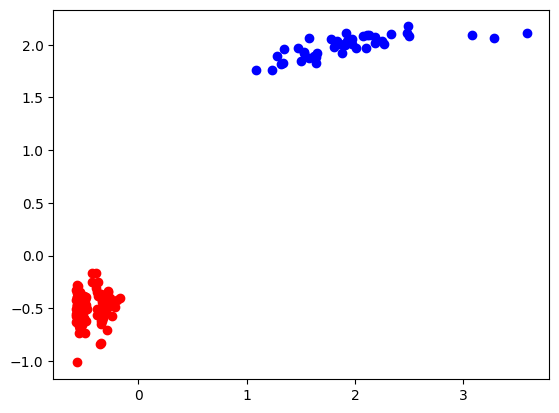

In [10]:
if len(burst_peaks) > 2:
    isReverb, percent_overlapping_IBI, percent_overlapping_FR, IBI, FR, labels, centers, dst = drc.k_means(burst_peaks, burst_borders, weighted_network_sdf)
    plt.scatter(IBI[labels==1], FR[labels==1], color='blue')
    plt.scatter(IBI[labels==0], FR[labels==0], color='red')

## Relabels and redraw Raster-SDF with labeled peaks
Probably not the best approach, but relabel the clustering labels so they reflect consistent types of bursts.

In [11]:
if min(FR[np.where(labels==0)]) < 0:
    prime_label = 1
else:
    prime_label = 0

prime_ind = [l+1 for l in np.where(labels==prime_label)][0]
prime_burst_peaks = burst_peaks[prime_ind]
nonprime_ind = [l+1 for l in np.where(labels!=prime_label)][0]
nonprime_burst_peaks = burst_peaks[nonprime_ind]

if weighted_network_sdf[(burst_peaks[0] * fs).astype(int)] >= np.mean(weighted_network_sdf[(prime_burst_peaks * fs).astype(int)])-2*np.std(weighted_network_sdf[(prime_burst_peaks * fs).astype(int)]):
    prime_burst_peaks = np.concatenate(([burst_peaks[0]], prime_burst_peaks))
else:
    nonprime_burst_peaks = np.concatenate(([burst_peaks[0]], nonprime_burst_peaks))

        

Text(0, 0.5, 'Active channels')

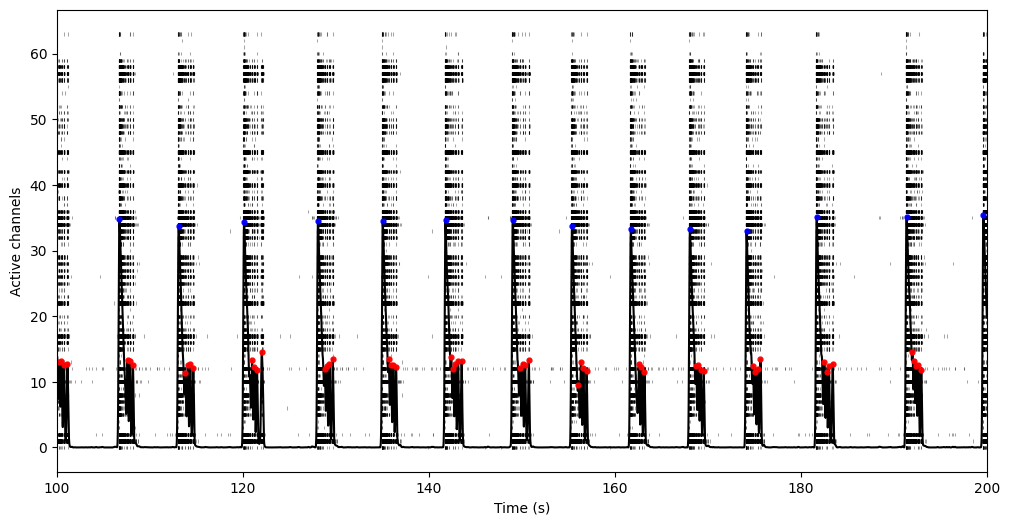

In [12]:
fig = plt.figure(figsize=(12, 6))    
plt.eventplot(raster, color='black', linelengths=0.5, linewidths=0.75, alpha=0.35)
t = np.arange(0, len(weighted_network_sdf) / fs, 1 / fs)
plt.plot(t, weighted_network_sdf, 'black', 3)
plt.plot(prime_burst_peaks, weighted_network_sdf[(prime_burst_peaks*fs).astype(int)],'.', color='blue', alpha=0.95, markersize=7)
plt.plot(nonprime_burst_peaks, weighted_network_sdf[(nonprime_burst_peaks*fs).astype(int)],'.', color='red', alpha=0.95, markersize=7)
plt.xlim([100,200])
plt.xlabel("Time (s)")
plt.ylabel("Active channels")

## Calculate reverberations features
Only calculate reverberation features if there are more than 5 bursts and has an inter-burst-interval (IBI) distribution that is right skew. If the network fulfills those criteria, calculate R_max which is the maximum local minima of a bimodal IBI distribution. Merge potential reverberating bursts if IBI between subsequent bursts is less than Rmax (supposedly belonging to a reverberating super burst).

In [13]:
if len(burst_peaks) > 5:
    if (brt.burst_skewness_reverberating(burst_peaks) == True):
        print("Skewness determined this well may be reverberating")
        try:
            rmax = brt.find_rmax_hist(burst_peaks, prime_burst_peaks)
            sb_start, sb_end, num_reverbs = brt.detect_reverberations_merge3(burst_borders, burst_peaks,
                                                                                prime_burst_peaks, rmax)
        except:
            print("Burst Reverberation Toolbox ran into an error.")
    else:
        sb_start = [x[0] for x in burst_borders]
        sb_end = [x[1] for x in burst_borders]

    sb_duration = brt.super_burst_duration(sb_start, sb_end)
    isbi = brt.inter_super_burst_interval(sb_start, sb_end)

Skewness determined this well may be reverberating
New RMAX: 0.5156399999999961 using size: 140
New RMAX: 0.5179067625899243 using size: 139
New RMAX: 0.5202063768115903 using size: 138
New RMAX: 0.5225395620437918 using size: 137
New RMAX: 0.5249070588235256 using size: 136
New RMAX: 0.5273096296296258 using size: 135
New RMAX: 1.1222865671641757 using size: 134
New RMAX: 1.1292168421052597 using size: 133
New RMAX: 1.1329918699186958 using size: 123
New RMAX: 1.133681538461535 using size: 104
New RMAX: 1.142740970873783 using size: 103
New RMAX: 1.1519780392156829 using size: 102
New RMAX: 1.1594991304347793 using size: 92
New RMAX: 1.1688546341463382 using size: 82
New RMAX: 1.1808088888888855 using size: 81
New RMAX: 1.1946152112676023 using size: 71
New RMAX: 1.1966193548387063 using size: 62
New RMAX: 1.2129481967213083 using size: 61
New RMAX: 1.218510769230766 using size: 52
New RMAX: 1.2384705882352909 using size: 51
New RMAX: 1.2508266666666634 using size: 42
New RMAX: 1.2764

/Users/kartik/Dropbox/ips2 (1)/code/Burst Reverberation Manuscript/Code/Reverberation_Tutorial/functions/burst_reverberation_toolbox_v2.py:114: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  if (rmax_tmp > rmax) & (rmax_tmp < (mode(list(map(int,prime_x)))[0]*0.9)):


## Redraw burst boundaries

Text(0, 0.5, 'Active channels')

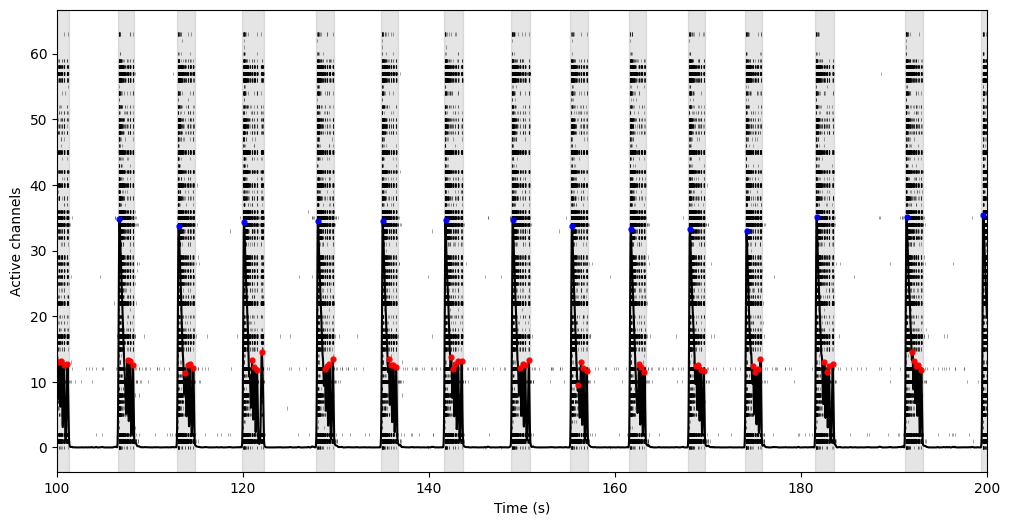

In [14]:
fig = plt.figure(figsize=(12, 6))    
plt.eventplot(raster, color='black', linelengths=0.5, linewidths=0.75, alpha=0.35)
t = np.arange(0, len(weighted_network_sdf) / fs, 1 / fs)
plt.plot(t, weighted_network_sdf, 'black', 3)
plt.plot(prime_burst_peaks, weighted_network_sdf[(prime_burst_peaks*fs).astype(int)],'.', color='blue', alpha=0.95, markersize=7)
plt.plot(nonprime_burst_peaks, weighted_network_sdf[(nonprime_burst_peaks*fs).astype(int)],'.', color='red', alpha=0.95, markersize=7)
for b in range(len(sb_start)):
    plt.axvspan(sb_start[b], sb_end[b], alpha=0.1, color='black')
plt.xlim([100,200])
plt.xlabel("Time (s)")
plt.ylabel("Active channels")

Text(0.5, 1.0, 'Super-Burst Duration')

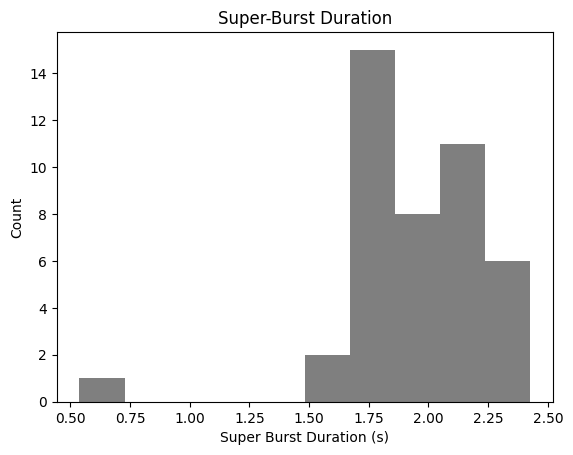

In [15]:
'''
Super-Burst Duration
'''
plt.hist(sb_duration, 10, color='black', alpha=0.5)
plt.xlabel("Super Burst Duration (s)")
plt.ylabel("Count")
plt.title("Super-Burst Duration")

Text(0.5, 1.0, 'Super Burst Frequency')

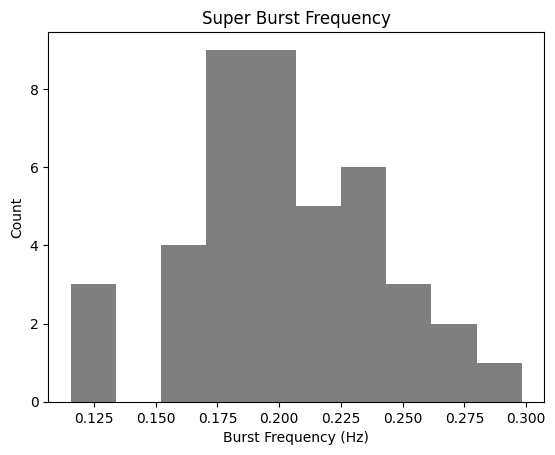

In [16]:
'''
Burst Frequency
'''
plt.hist([1/i for i in isbi], 10, color='black', alpha=0.5)
plt.xlabel("Burst Frequency (Hz)")
plt.ylabel("Count")
plt.title("Super Burst Frequency")


Text(0, 0.5, 'Super Burst Duration (s)')

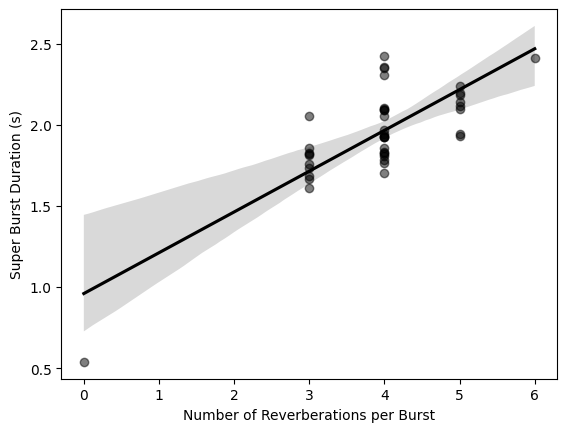

In [29]:
sns.regplot(x=num_reverbs, y=sb_duration, color='black', scatter_kws={'alpha':0.5})
plt.xlabel("Number of Reverberations per Burst")
plt.ylabel("Super Burst Duration (s)")